## Setup


In [31]:
import numpy as np
import os
from typing import Sequence

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import OPTICS
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import BallTree
from torch.utils.data import Dataset, DataLoader
import pandas as pd

## Simulation


In [32]:
seed = 99
save_plot = False
use_cached_distance_matrix = True

np.random.seed(seed)

cases = generate_cases(1000)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
crashed = sum(1 for r in valid_results if r.crashed)
print(
    f"Generated {len(trajectories)} valid trajectories ({crashed} crashed, {len(trajectories)-crashed} safe)"
)

KeyboardInterrupt: 

In [ ]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    distance_matrix = np.load(distance_matrix_file)
else:
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)

print(f"Distance matrix: {distance_matrix.shape}")

Distance matrix: (328, 328)


## OPTIC Clustering


In [ ]:
# OPTICS clustering based on altitude trajectories
optics = OPTICS(min_samples=3, metric="precomputed", cluster_method="xi", xi=0.05)
clusters = optics.fit_predict(distance_matrix)
unique_clusters = np.unique(clusters)
reachability = optics.reachability_
ordering = optics.ordering_

print(f"OPTICS: {len(unique_clusters)} clusters (excluding noise)")

OPTICS: 33 clusters (excluding noise)


In [ ]:
# Calculate coverage metrics
total_test_cases = len(valid_results)
noise_points = np.sum(clusters == -1)
cluster_ids = unique_clusters[unique_clusters != -1]  # Exclude noise
num_clusters = len(cluster_ids)

# Calculate cluster sizes and proportions
cluster_sizes = {}
cluster_proportions = {}
cluster_coverage_percentages = {}

for cluster_id in cluster_ids:
    cluster_mask = clusters == cluster_id
    size = np.sum(cluster_mask)
    cluster_sizes[cluster_id] = size
    cluster_proportions[cluster_id] = (
        size / total_test_cases if total_test_cases > 0 else 0
    )
    cluster_coverage_percentages[cluster_id] = cluster_proportions[cluster_id] * 100

# Store coverage metrics
coverage_metrics = {
    "total_test_cases": total_test_cases,
    "num_clusters": num_clusters,
    "noise_points": noise_points,
    "noise_percentage": (
        (noise_points / total_test_cases * 100) if total_test_cases > 0 else 0
    ),
    "cluster_sizes": cluster_sizes,
    "cluster_proportions": cluster_proportions,
    "cluster_coverage_percentages": cluster_coverage_percentages,
}

In [ ]:
# Print coverage metrics summary
total_test_cases = len(valid_results)
noise_points = np.sum(clusters == -1)
cluster_ids = unique_clusters[unique_clusters != -1]
num_clusters = len(cluster_ids)

cluster_sizes = {cid: np.sum(clusters == cid) for cid in cluster_ids}

print(
    f"OPTICS Coverage: {total_test_cases} cases, {num_clusters} clusters, {noise_points} noise ({noise_points/total_test_cases*100:.1f}%)"
)
print(
    f"Cluster sizes - Min: {min(cluster_sizes.values())}, Max: {max(cluster_sizes.values())}, Mean: {np.mean(list(cluster_sizes.values())):.1f}"
)

OPTICS Coverage: 328 cases, 32 clusters, 174 noise (53.0%)
Cluster sizes - Min: 3, Max: 12, Mean: 4.8


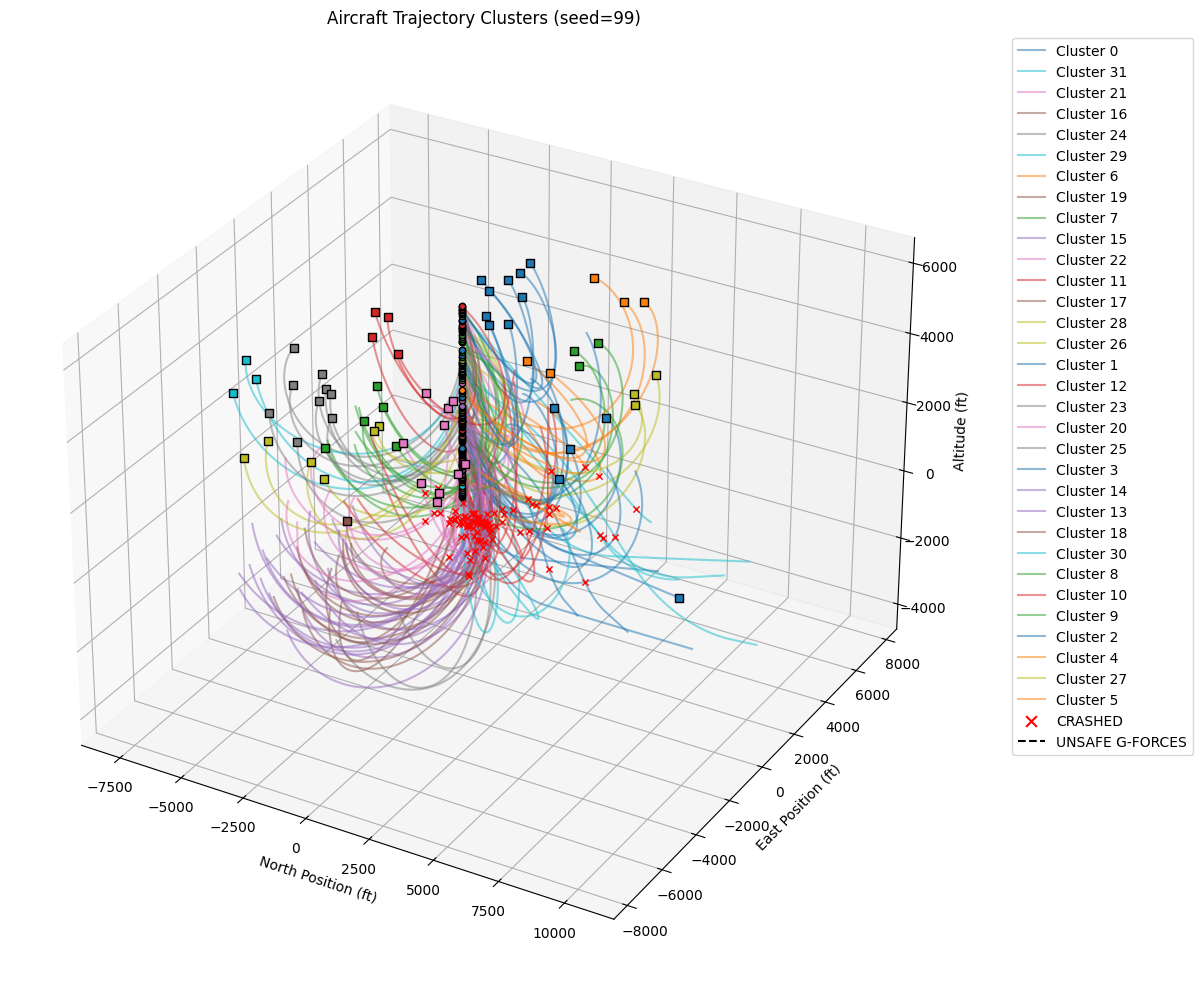

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

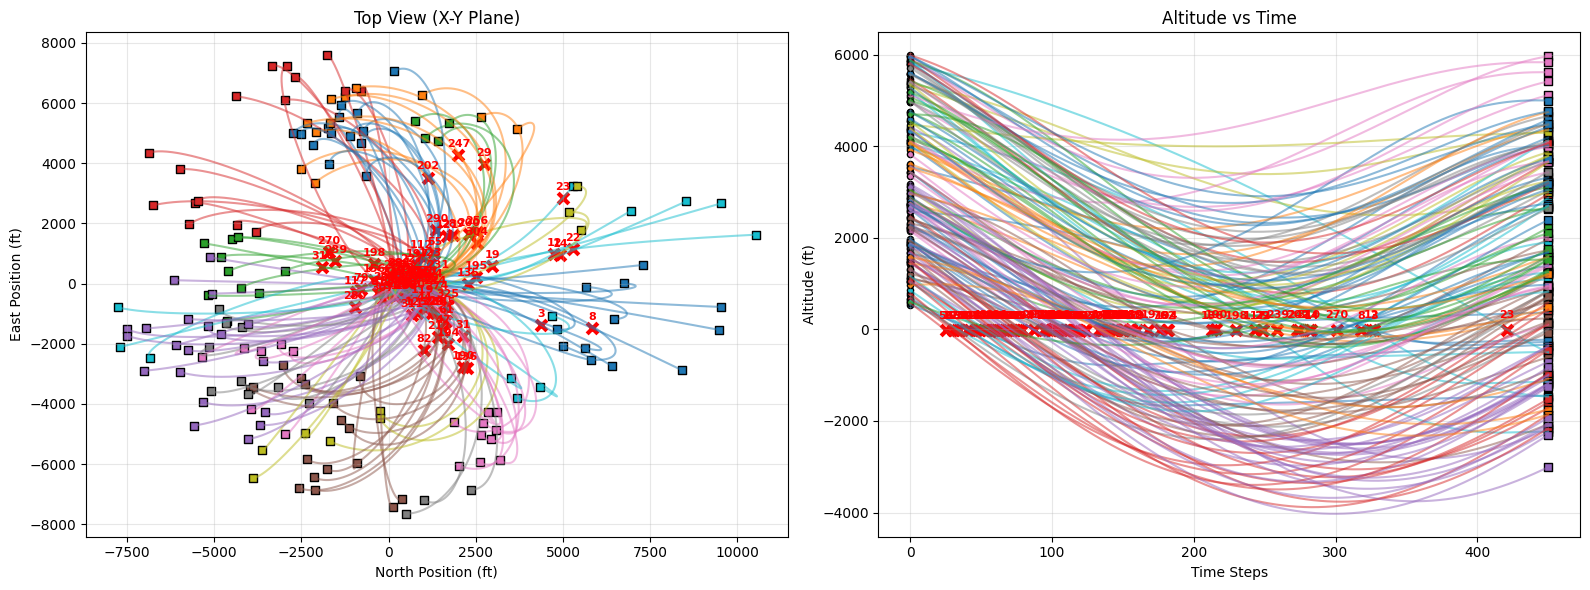

In [ ]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")

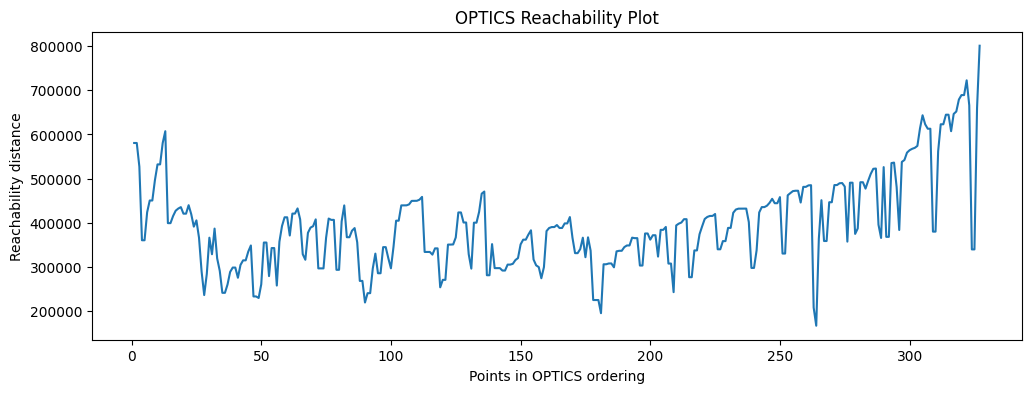

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(reachability[ordering])
plt.xlabel("Points in OPTICS ordering")
plt.ylabel("Reachability distance")
plt.title("OPTICS Reachability Plot")
plt.show()

## Gaussian Mixture Model (GMM) Clustering


In [ ]:
# Apply MDS to convert altitude-based distance matrix to feature space
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=seed)
X_transformed = mds.fit_transform(distance_matrix)
print(f"MDS: {X_transformed.shape}, stress={mds.stress_:.4f}")

/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


FloatingPointError: divide by zero encountered in matmul

In [ ]:
# Apply GMM clustering with n=5 components based on altitude trajectories
n_components = 5
gmm = GaussianMixture(n_components=n_components, random_state=seed)
gmm.fit(X_transformed)
clusters = gmm.predict(X_transformed)
cluster_probs = gmm.predict_proba(X_transformed)
unique_clusters = np.unique(clusters)
print(f"GMM: {n_components} components")

Applying GMM clustering with 5 components...


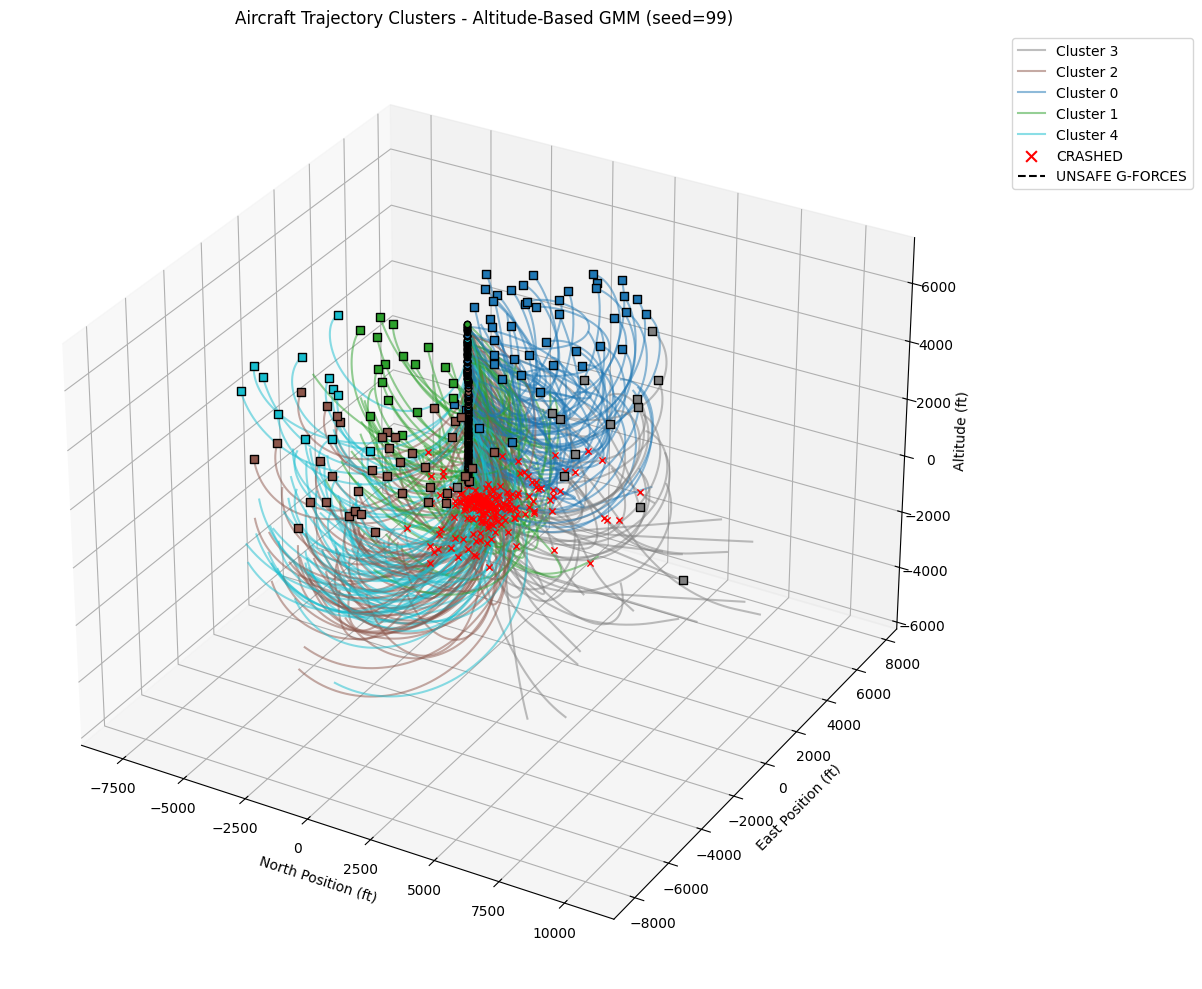

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        # Safe landing point
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

# Add legend for crashed trajectories
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters - Altitude-Based GMM (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_3d.png", dpi=300, bbox_inches="tight"
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_3d.png")

plt.show()

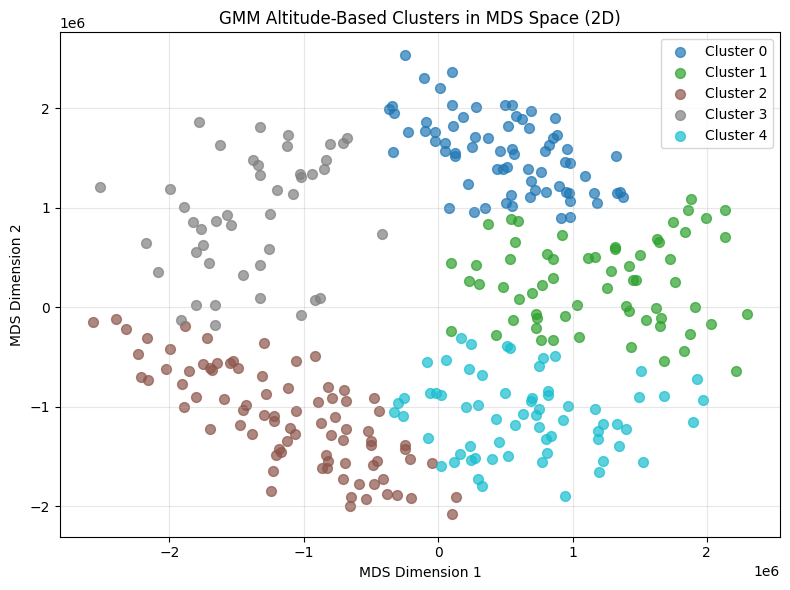

In [ ]:
# Visualize clusters in MDS space
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    # Plot first two MDS dimensions
    ax1.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_title("GMM Altitude-Based Clusters in MDS Space (2D)")
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()

if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_mds.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"MDS plot saved to results/gmm_{n_components}_clusters_mds.png")

plt.show()

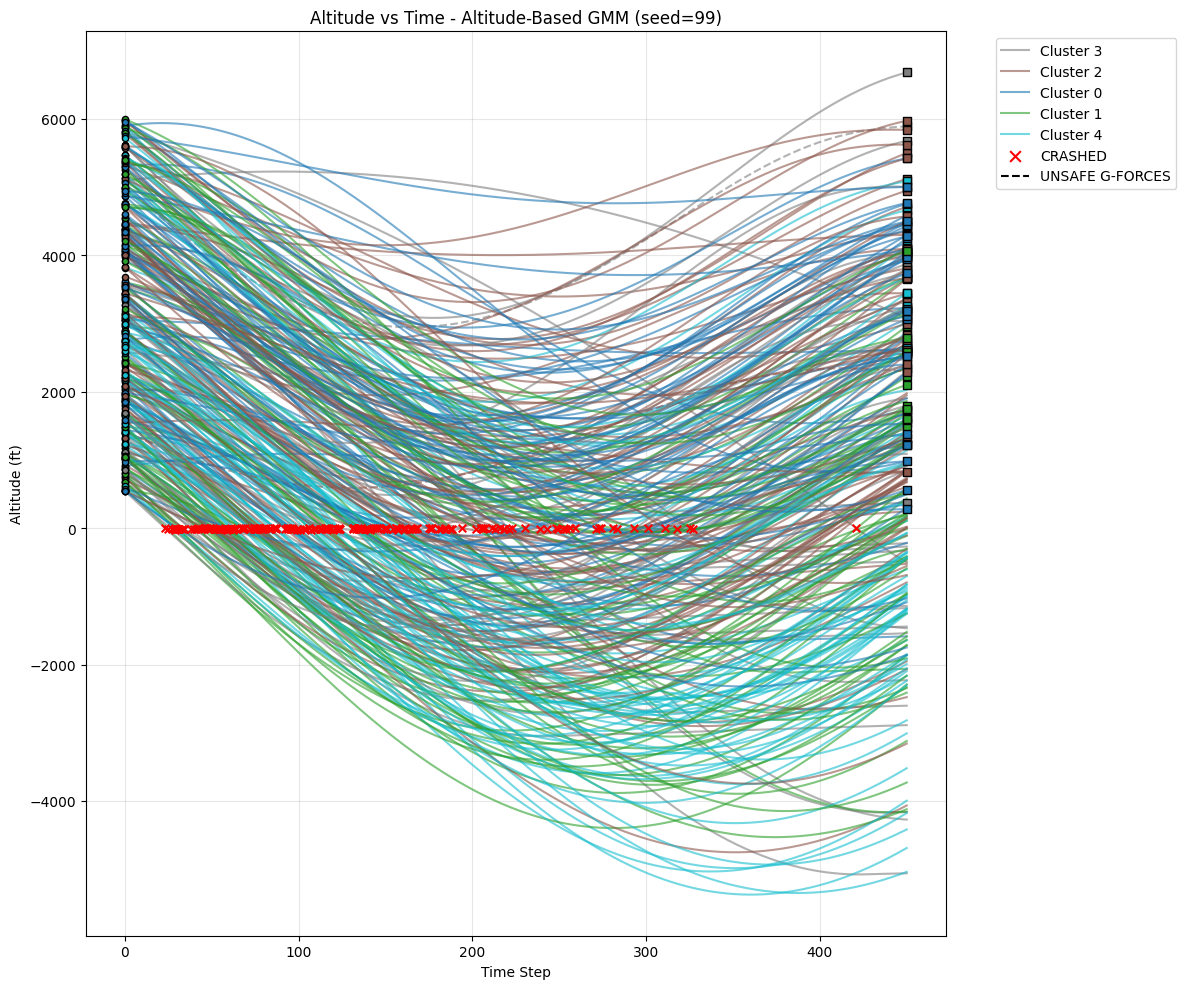

In [ ]:
# Altitude vs Time Visualization
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
plotted_clusters = set()

for traj, cluster_id, result in zip(trajectories, clusters, valid_results):
    color = colors[cluster_id % len(colors)]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    plotted_clusters.add(cluster_id)

    # Style for unsafe g-forces
    line_style = "--" if has_unsafe_gforces(traj) else "-"

    # Time index and altitude
    t = np.arange(traj.shape[0])
    alt = traj[:, 2]

    # Plot altitude vs time
    ax.plot(
        t,
        alt,
        color=color,
        alpha=0.6,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # Start point
    ax.scatter(
        0,
        alt[0],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
        zorder=3,
    )

    # End point (crash or safe)
    if result.crashed:
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]
            crash_t = crash_idx
            crash_alt = alt[crash_idx]
        else:
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_t = min_alt_idx
            crash_alt = alt[min_alt_idx]
        ax.scatter(
            crash_t, crash_alt, color="red", s=30, marker="x", linewidth=1.5, zorder=4
        )
    else:
        ax.scatter(
            t[-1],
            alt[-1],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
            zorder=4,
        )

# Legend handles
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("Time Step")
ax.set_ylabel("Altitude (ft)")
ax.set_title(f"Altitude vs Time - Altitude-Based GMM (seed={seed})")
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

if save_plot:
    os.makedirs("results", exist_ok=True)
    plt.savefig(
        f"results/gmm_{n_components}_clusters_altitude_time.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_altitude_time.png")

plt.show()

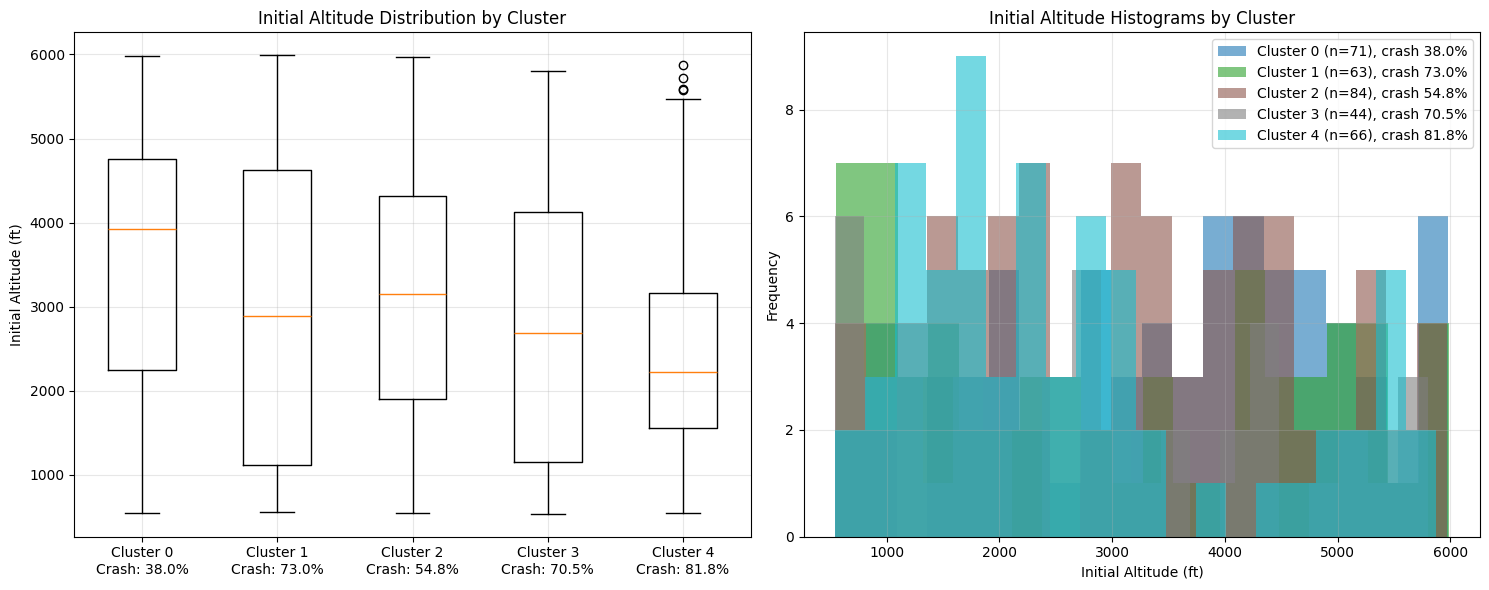

In [ ]:
# Visualize altitude distributions by cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of altitude by cluster
cluster_alts = []
cluster_labels = []
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0
    cluster_alts.append(cluster_altitudes)
    cluster_labels.append(f"Cluster {cluster_id}\nCrash: {crash_rate:.1f}%")

ax1.boxplot(cluster_alts, tick_labels=cluster_labels)
ax1.set_ylabel("Initial Altitude (ft)")
ax1.set_title("Initial Altitude Distribution by Cluster")
ax1.grid(True, alpha=0.3)

# Histogram of altitude distributions
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
for i, cluster_id in enumerate(unique_clusters):
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0

    ax2.hist(
        cluster_altitudes,
        bins=20,
        alpha=0.6,
        label=f"Cluster {cluster_id} (n={len(cluster_altitudes)}), crash {crash_rate:.1f}%",
        color=colors[i % len(colors)],
    )

ax2.set_xlabel("Initial Altitude (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Initial Altitude Histograms by Cluster")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variable -> Crash relationship summary
--------------------------------------------------
Altitude (ft)    | corr=-0.656 | safe mean=4406.29 | crash mean=2254.15
Velocity (ft/s)  | corr=-0.066 | safe mean=719.27 | crash mean=711.03
Alpha (deg)      | corr=-0.073 | safe mean=5.33 | crash mean=4.90
Beta (deg)       | corr=+0.038 | safe mean=-0.97 | crash mean=-0.07
Phi (deg)        | corr=-0.060 | safe mean=8.45 | crash mean=-6.40
Theta (deg)      | corr=+0.016 | safe mean=-49.94 | crash mean=-49.10
Power            | corr=+0.000 | safe mean=9.00 | crash mean=9.00


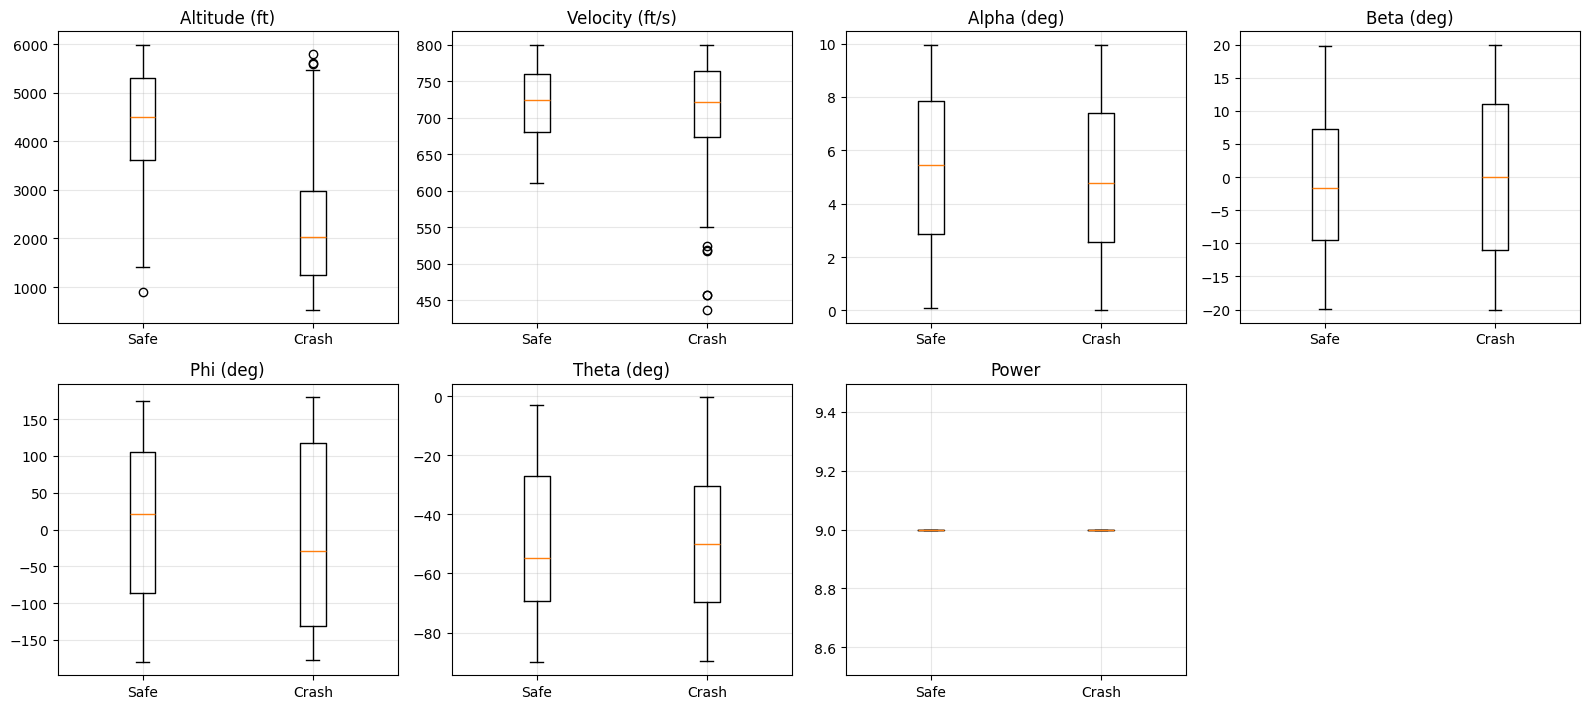

In [ ]:
# Relationship of initial variables to crash outcome
from sklearn.metrics import roc_auc_score

# Collect initial variables and crash labels
labels = np.array([1 if r.crashed else 0 for r in valid_results])
vars_dict = {
    "Altitude (ft)": np.array([r.test_case.alt for r in valid_results]),
    "Velocity (ft/s)": np.array([r.test_case.vt for r in valid_results]),
    "Alpha (deg)": np.rad2deg(np.array([r.test_case.alpha for r in valid_results])),
    "Beta (deg)": np.rad2deg(np.array([r.test_case.beta for r in valid_results])),
    "Phi (deg)": np.rad2deg(np.array([r.test_case.phi for r in valid_results])),
    "Theta (deg)": np.rad2deg(np.array([r.test_case.theta for r in valid_results])),
    "Power": np.array([r.test_case.power for r in valid_results]),
}

print("Variable -> Crash relationship summary")
print("-" * 50)
for name, values in vars_dict.items():
    # Pearson correlation with binary label (point-biserial equivalent)
    corr = float(np.corrcoef(values, labels)[0, 1]) if np.std(values) > 0 else 0.0
    safe_vals = values[labels == 0]
    crash_vals = values[labels == 1]
    print(
        f"{name:16s} | corr={corr:+.3f} | safe mean={np.mean(safe_vals):.2f} | crash mean={np.mean(crash_vals):.2f}"
    )

# Boxplots comparing crashed vs safe for each variable
num_vars = len(vars_dict)
cols = 4
rows = int(np.ceil(num_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
axes = axes.flatten()

for ax, (name, values) in zip(axes, vars_dict.items()):
    data = [values[labels == 0], values[labels == 1]]
    ax.boxplot(data, tick_labels=["Safe", "Crash"])
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(len(vars_dict), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Training Util Functions


In [ ]:
from typing import Union


def testcase_to_ndarray(test_case: TestCase) -> np.ndarray:

    return np.array(
        [
            test_case.vt,
            test_case.alpha,
            test_case.beta,
            test_case.phi,
            test_case.theta,
            test_case.psi,
            test_case.alt,
            test_case.power,
        ]
    )


test_cases = [r.test_case for r in valid_results]
features = np.array([testcase_to_ndarray(case) for case in test_cases])
features.shape


def pair_features_between(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    feat_diff = a - b
    feat_abs_diff = np.abs(feat_diff)
    euclidean_dist = np.linalg.norm(feat_diff)
    angular_indices = [1, 2, 3, 4, 5]
    angular_diffs = []
    for idx in angular_indices:
        d = feat_diff[idx]
        while d > np.pi:
            d -= 2 * np.pi
        while d < -np.pi:
            d += 2 * np.pi
        angular_diffs.append(d)
    return np.concatenate([feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs])


def ndarray_to_testcase(arr: Union[Sequence[float], np.ndarray]) -> TestCase:
    return TestCase(
        vt=float(arr[0]),
        alpha=float(arr[1]),
        beta=float(arr[2]),
        phi=float(arr[3]),
        theta=float(arr[4]),
        psi=float(arr[5]),
        alt=float(arr[6]),
        power=float(arr[7]),
    )

In [ ]:
def create_pairwise_features(
    features: NDArray[np.float64], distance_matrix: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    n = features.shape[0]
    pairwise_features = []
    distances = []
    real_euclidean = []
    real_dtw = []

    for i in range(n):
        for j in range(i, n):
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)
            euclidean_dist = np.linalg.norm(feat_diff)

            angular_indices = [1, 2, 3, 4, 5]
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            combined_features = np.concatenate(
                [feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

            if i != j:
                real_euclidean.append(euclidean_dist)
                real_dtw.append(distance_matrix[i, j])

    # Data Augmentation: Add synthetic "near" neighbors
    if len(real_euclidean) > 0:
        ratios = np.array(real_dtw) / (np.array(real_euclidean) + 1e-8)
        avg_ratio = np.median(ratios)

        n_synthetic = 5
        feature_std = np.std(features, axis=0)
        feature_std[feature_std == 0] = 1.0

        for i in range(n):
            for _ in range(n_synthetic):
                noise_scale = np.random.uniform(0.01, 0.05)
                noise = np.random.normal(0, feature_std * noise_scale)
                feat_neighbor = features[i] + noise

                feat_diff = features[i] - feat_neighbor
                feat_abs_diff = np.abs(feat_diff)
                euclidean_dist = np.linalg.norm(feat_diff)

                angular_diffs = []
                for idx in angular_indices:
                    diff = feat_diff[idx]
                    while diff > np.pi:
                        diff -= 2 * np.pi
                    while diff < -np.pi:
                        diff += 2 * np.pi
                    angular_diffs.append(diff)

                combined_features = np.concatenate(
                    [feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs]
                )

                estimated_dist = avg_ratio * euclidean_dist
                pairwise_features.append(combined_features)
                distances.append(estimated_dist)

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features(features, distance_matrix)
print(f"Pairwise features: {X.shape}, distances: {y.shape}")

Pairwise features: (55596, 22), distances: (55596,)


## Random Forest Regression


In [ ]:
# Split data and normalize
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 44476, Test: 11120


In [ ]:
initial_cases = [r.test_case for r in valid_results]

In [ ]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99)

In [ ]:
# Evaluate Random Forest
rf_predictions = rf_model.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)
print(f"RF: MAE={rf_mae:.2f}, RMSE={rf_rmse:.2f}, R²={rf_r2:.4f}")

RF: MAE=290699.34, RMSE=396342.63, R²=0.8118


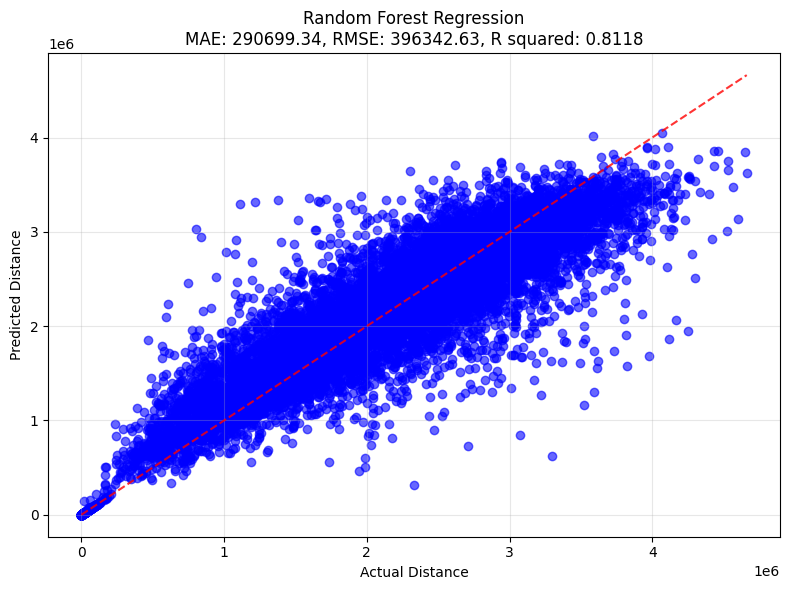

In [ ]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R squared: {rf_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Neural Network Regression


In [ ]:
# Define Neural Network Model
class DistancePredictorNN(nn.Module):
    def __init__(self, input_dim):
        super(DistancePredictorNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.model(x)


X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
print(f"Train tensor: {X_train_tensor.shape}, Test tensor: {X_test_tensor.shape}")

Train tensor: torch.Size([44476, 22]), Test tensor: torch.Size([11120, 22])


In [ ]:
# Train Neural Network Regressor
torch.manual_seed(seed)
batch_size = 64
epochs = 100
lr = 0.001

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

nn_model = DistancePredictorNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=lr)

nn_model.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(f"NN training complete ({epochs} epochs)")

NN training complete (100 epochs)


In [ ]:
# Evaluate NN
nn_model.eval()
with torch.no_grad():
    nn_predictions = nn_model(X_test_tensor).numpy().flatten()

nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
nn_r2 = r2_score(y_test, nn_predictions)
print(f"NN: MAE={nn_mae:.2f}, RMSE={nn_rmse:.2f}, R²={nn_r2:.4f}")

NN: MAE=322342.34, RMSE=428761.98, R²=0.7797


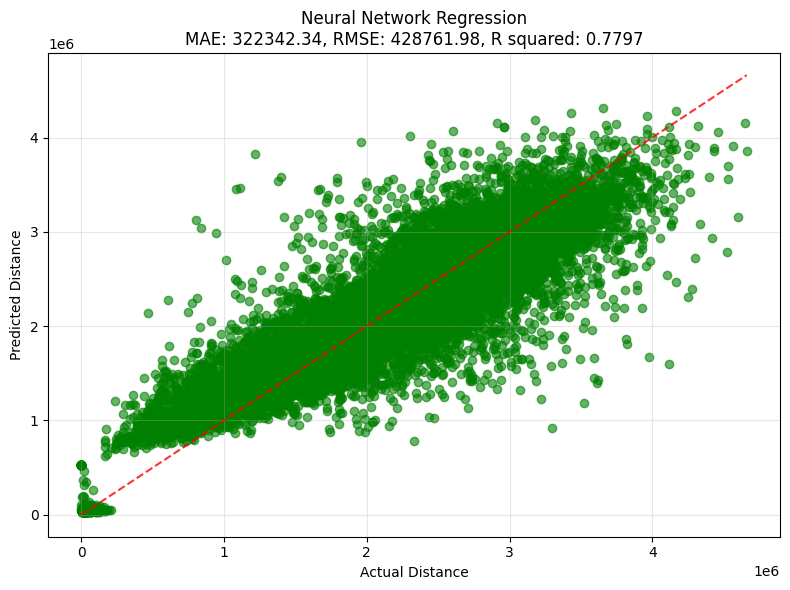

In [ ]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, nn_predictions, alpha=0.6, color="green")
min_val = min(y_test.min(), nn_predictions.min())
max_val = max(y_test.max(), nn_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Neural Network Regression\nMAE: {nn_mae:.2f}, RMSE: {nn_rmse:.2f}, R squared: {nn_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Triplet Loss Encoder


In [ ]:
class TripletEncoder(nn.Module):
    def __init__(self, input_dim=8, latent_dim=32, normalize_output=True):
        super(TripletEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()
        self.normalize_output = normalize_output

    def forward(self, x) -> torch.Tensor:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.normalize_output:
            x = nn.functional.normalize(x, p=2, dim=1)
        return x

In [ ]:
# Create TripletDataset class for generating anchor-positive-negative triplets
class TripletDataset(Dataset):
    def __init__(
        self,
        features,
        distance_matrix,
        n_triplets,
        positive_threshold_percentile=20,
        negative_threshold_percentile=80,
        random_seed=100,
    ):
        """
        Args:
            features: numpy array of shape (n_samples, n_features)
            distance_matrix: numpy array of shape (n_samples, n_samples) with DTW distances
            n_triplets: number of triplets to generate
            positive_threshold_percentile: percentile threshold for positive examples (lower = closer)
            negative_threshold_percentile: percentile threshold for negative examples (higher = farther)
            random_seed: random seed for reproducibility
        """
        self.features = features
        self.distance_matrix = distance_matrix
        self.n_triplets = n_triplets
        self.n_samples = len(features)

        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

        # Pre-compute thresholds
        # Get all non-zero distances (excluding diagonal)
        mask = ~np.eye(self.n_samples, dtype=bool)
        all_distances = self.distance_matrix[mask]
        self.positive_threshold = np.percentile(
            all_distances, positive_threshold_percentile
        )
        self.negative_threshold = np.percentile(
            all_distances, negative_threshold_percentile
        )

        # Pre-generate triplets
        self.triplets = []
        max_attempts = 1000
        for _ in range(n_triplets):
            anchor_idx = np.random.randint(0, self.n_samples)
            attempts = 0
            positive_idx = None
            negative_idx = None

            # Find positive (similar to anchor)
            while positive_idx is None and attempts < max_attempts:
                candidate = np.random.randint(0, self.n_samples)
                if candidate != anchor_idx:
                    dist = self.distance_matrix[anchor_idx, candidate]
                    if dist <= self.positive_threshold:
                        positive_idx = candidate
                attempts += 1

            # Find negative (dissimilar to anchor)
            attempts = 0
            while negative_idx is None and attempts < max_attempts:
                candidate = np.random.randint(0, self.n_samples)
                if candidate != anchor_idx and candidate != positive_idx:
                    dist = self.distance_matrix[anchor_idx, candidate]
                    if dist >= self.negative_threshold:
                        negative_idx = candidate
                attempts += 1

            if positive_idx is not None and negative_idx is not None:
                self.triplets.append((anchor_idx, positive_idx, negative_idx))
            elif len(self.triplets) > 0:
                # If we can't find valid triplet, reuse a previous one
                self.triplets.append(self.triplets[-1])

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]
        anchor = torch.FloatTensor(self.features[anchor_idx])
        positive = torch.FloatTensor(self.features[positive_idx])
        negative = torch.FloatTensor(self.features[negative_idx])
        return anchor, positive, negative

In [ ]:
# Implement triplet loss function
def triplet_loss(anchor_emb, positive_emb, negative_emb, margin=0.5):
    """
    Compute triplet loss: max(0, margin + d(anchor, positive) - d(anchor, negative))

    Args:
        anchor_emb: anchor embeddings (batch_size, latent_dim)
        positive_emb: positive embeddings (batch_size, latent_dim)
        negative_emb: negative embeddings (batch_size, latent_dim)
        margin: margin parameter for triplet loss

    Returns:
        Mean triplet loss over batch
    """
    # Compute squared L2 distances
    d_pos = torch.sum((anchor_emb - positive_emb) ** 2, dim=1)
    d_neg = torch.sum((anchor_emb - negative_emb) ** 2, dim=1)

    # Triplet loss: max(0, margin + d_pos - d_neg)
    loss = torch.clamp(margin + d_pos - d_neg, min=0.0)
    return torch.mean(loss)

In [ ]:
# Training function for triplet encoder
def train_triplet_encoder(
    features,
    distance_matrix,
    latent_dim=32,
    margin=0.5,
    epochs=50,
    batch_size=64,
    lr=0.001,
    n_triplets=10000,
    random_seed=100,
):

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Create dataset and dataloader
    dataset = TripletDataset(
        features_scaled, distance_matrix, n_triplets, random_seed=random_seed
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize encoder
    encoder = TripletEncoder(input_dim=features.shape[1], latent_dim=latent_dim)
    optimizer = optim.Adam(encoder.parameters(), lr=lr)

    # Set random seeds
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

    # Training loop
    encoder.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for anchor, positive, negative in dataloader:
            optimizer.zero_grad()

            # Forward pass
            anchor_emb = encoder(anchor)
            positive_emb = encoder(positive)
            negative_emb = encoder(negative)

            # Compute loss
            loss = triplet_loss(anchor_emb, positive_emb, negative_emb, margin=margin)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches if n_batches > 0 else 0.0
        loss_history.append(avg_loss)

    return encoder, scaler, loss_history

In [ ]:
# Encoder-based novelty search function using BallTree
def run_active_coverage_cycles_with_encoder(
    init_cases: list[TestCase],
    cycles: int = 5,
    per_cycle_new: int = 20,
    n_candidates: int = 50000,
    latent_dim: int = 8,
    encoder_epochs: int = 50,
    seed: int = 100,
    cache_distances: bool = True,
):
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    results_all = evaluate_cases(init_cases)
    valid_results = [r for r in results_all if not r.simulation_failed]
    trajectories = [r.trajectory for r in valid_results]
    test_cases = [r.test_case for r in valid_results]
    features = np.array([testcase_to_ndarray(tc) for tc in test_cases])

    distance_matrix_file = (
        f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"
    )
    if cache_distances and os.path.exists(distance_matrix_file):
        distance_matrix = np.load(distance_matrix_file)
    else:
        distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
        if cache_distances:
            os.makedirs("cache", exist_ok=True)
            np.save(distance_matrix_file, distance_matrix)

    encoder, scaler, loss_history = train_triplet_encoder(
        features,
        distance_matrix,
        latent_dim=latent_dim,
        epochs=encoder_epochs,
        random_seed=seed,
    )

    encoder.eval()
    with torch.no_grad():
        features_scaled = scaler.transform(features)
        latent_vectors = encoder(torch.FloatTensor(features_scaled)).numpy()

    balltree = BallTree(latent_vectors)

    for c in range(1, cycles + 1):
        feat_min = features.min(axis=0)
        feat_max = features.max(axis=0)
        candidates = rng.uniform(
            low=feat_min, high=feat_max, size=(n_candidates, features.shape[1])
        )

        candidates_scaled = scaler.transform(candidates)
        encoder.eval()
        with torch.no_grad():
            candidate_latent = encoder(torch.FloatTensor(candidates_scaled)).numpy()

        distances, _ = balltree.query(candidate_latent, k=1)
        min_distances = distances.flatten()

        top_indices = np.argsort(min_distances)[-per_cycle_new:][::-1]
        selected_candidates = candidates[top_indices]

        new_cases = [ndarray_to_testcase(cand) for cand in selected_candidates]
        new_results = evaluate_cases(new_cases)
        new_valid = [r for r in new_results if not r.simulation_failed]

        results_all.extend(new_results)
        new_trajectories = [r.trajectory for r in new_valid]
        new_test_cases = [r.test_case for r in new_valid]
        new_features = np.array([testcase_to_ndarray(tc) for tc in new_test_cases])

        new_features_scaled = scaler.transform(new_features)
        encoder.eval()
        with torch.no_grad():
            new_latent = encoder(torch.FloatTensor(new_features_scaled)).numpy()

        latent_vectors = np.vstack([latent_vectors, new_latent])
        balltree = BallTree(latent_vectors)

        trajectories.extend(new_trajectories)
        test_cases.extend(new_test_cases)
        features = np.vstack([features, new_features])

    trajectories_all = [r.trajectory for r in results_all if not r.simulation_failed]
    features_all = np.array(
        [
            testcase_to_ndarray(r.test_case)
            for r in results_all
            if not r.simulation_failed
        ]
    )

    return results_all, trajectories_all, features_all

## Coverage Distance


In [35]:
from sklearn.neighbors import BallTree
import time

LATENT_DIM = 32

In [42]:
def coverage_distance_with_predictor(
    init_cases,
    cycles=3,
    n_candidates=10000,
    latent_dim=LATENT_DIM,
    encoder_epochs=30,
    n_triplets=5000,
    seed=100,
    cache_distances=True,
):
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("Proposed Method: Distance Predictor + Encoder on Predicted Distances")
    # Evaluate initial cases
    results = evaluate_cases(init_cases)
    valid_results = [r for r in results if not r.simulation_failed]
    trajectories = [r.trajectory for r in valid_results]
    features = np.array([testcase_to_ndarray(r.test_case) for r in valid_results])

    # Calculate actual DTW distance matrix for training predictor
    distance_matrix_file = (
        f"cache/coverage_dist_matrix_seed{seed}_size{len(trajectories)}.npy"
    )
    if cache_distances and os.path.exists(distance_matrix_file):
        actual_distance_matrix = np.load(distance_matrix_file)
    else:
        actual_distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
        if cache_distances:
            os.makedirs("cache", exist_ok=True)
            np.save(distance_matrix_file, actual_distance_matrix)
    # Train distance predictor
    X_pairwise, y_pairwise = create_pairwise_features(features, actual_distance_matrix)
    # Split for training (use all data for predictor since we need predictions for all pairs)
    scaler_predictor = StandardScaler()
    X_pairwise_scaled = scaler_predictor.fit_transform(X_pairwise)
    predictor = RandomForestRegressor(
        n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
    )
    predictor.fit(X_pairwise_scaled, y_pairwise)

    # Compute predicted distance matrix
    n = len(features)
    predicted_distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i == j:
                predicted_distance_matrix[i, j] = 0.0
            else:
                pair_features = pair_features_between(features[i], features[j])
                pair_features_scaled = scaler_predictor.transform(
                    pair_features.reshape(1, -1)
                )
                pred = predictor.predict(pair_features_scaled)[0]
                predicted_distance_matrix[i, j] = pred
                predicted_distance_matrix[j, i] = pred

    # Train encoder on PREDICTED distances (not actual DTW distances)
    encoder, scaler_encoder, _ = train_triplet_encoder(
        features,
        predicted_distance_matrix,  # Use predicted distances, not actual!
        latent_dim=latent_dim,
        epochs=encoder_epochs,
        n_triplets=n_triplets,
        random_seed=seed,
    )
    # Encode all initial conditions
    encoder.eval()
    with torch.no_grad():
        features_scaled = scaler_encoder.transform(features)
        features_tensor = torch.FloatTensor(features_scaled)
        latent_vectors = encoder(features_tensor).numpy()
    # Build BallTree on latent vectors
    balltree = BallTree(latent_vectors, metric="euclidean")
    # Active learning loop
    all_results = valid_results.copy()
    all_features = features.copy()
    all_latent = latent_vectors.copy()
    all_trajectories = trajectories.copy()
    # Track which points are initial vs newly generated
    point_types = ["initial"] * len(latent_vectors)
    coverage_history = []
    for cycle in range(1, cycles + 1):
        # Generate candidate initial conditions
        candidates = generate_cases(n_candidates)
        candidate_features = np.array([testcase_to_ndarray(c) for c in candidates])
        # Encode candidates
        with torch.no_grad():
            candidate_features_scaled = scaler_encoder.transform(candidate_features)
            candidate_features_tensor = torch.FloatTensor(candidate_features_scaled)
            candidate_latent = encoder(candidate_features_tensor).numpy()
        # Find farthest candidate from its nearest neighbor
        distances, indices = balltree.query(candidate_latent, k=1)
        distances = distances.flatten()
        indices = indices.flatten()
        best_idx = np.argmax(distances)
        best_candidate = candidates[best_idx]
        coverage_distance = distances[best_idx]
        # Determine if nearest neighbor is initial or newly generated
        nearest_neighbor_idx = indices[best_idx]
        nearest_neighbor_type = point_types[nearest_neighbor_idx]
        # Calculate separate coverage distances for initial vs newly generated points
        coverage_distance_initial = (
            distances[best_idx] if nearest_neighbor_type == "initial" else None
        )
        coverage_distance_new = (
            distances[best_idx] if nearest_neighbor_type == "new" else None
        )
        # Also check all candidates to find max distances to initial vs new points separately
        distances_to_initial = []
        distances_to_new = []
        for i, nn_idx in enumerate(indices):
            if point_types[nn_idx] == "initial":
                distances_to_initial.append(distances[i])
            else:
                distances_to_new.append(distances[i])
        max_distance_to_initial = (
            max(distances_to_initial) if distances_to_initial else None
        )
        max_distance_to_new = max(distances_to_new) if distances_to_new else None
        # Evaluate best candidate
        new_results = evaluate_cases([best_candidate])
        new_valid = [r for r in new_results if not r.simulation_failed]
        if len(new_valid) == 0:
            continue
        # Add to collection
        all_results.extend(new_valid)
        new_features = np.array([testcase_to_ndarray(r.test_case) for r in new_valid])
        all_features = np.vstack([all_features, new_features])
        new_trajectories = [r.trajectory for r in new_valid]
        all_trajectories.extend(new_trajectories)
        # Update point types: add 'new' for each newly added point
        point_types.extend(["new"] * len(new_features))
        # Update predicted distance matrix
        n_new = len(new_features)
        n_old = len(predicted_distance_matrix)
        n_total = n_old + n_new
        # Expand predicted distance matrix
        new_predicted_matrix = np.zeros((n_total, n_total))
        new_predicted_matrix[:n_old, :n_old] = predicted_distance_matrix
        # Predict distances for new points
        for i in range(n_old):
            for j in range(n_old, n_total):
                pair_features = pair_features_between(all_features[i], all_features[j])
                pair_features_scaled = scaler_predictor.transform(
                    pair_features.reshape(1, -1)
                )
                pred = predictor.predict(pair_features_scaled)[0]
                new_predicted_matrix[i, j] = pred
                new_predicted_matrix[j, i] = pred
        # Predict distances between new points
        for i in range(n_old, n_total):
            for j in range(i, n_total):
                if i == j:
                    new_predicted_matrix[i, j] = 0.0
                else:
                    pair_features = pair_features_between(
                        all_features[i], all_features[j]
                    )
                    pair_features_scaled = scaler_predictor.transform(
                        pair_features.reshape(1, -1)
                    )
                    pred = predictor.predict(pair_features_scaled)[0]
                    new_predicted_matrix[i, j] = pred
                    new_predicted_matrix[j, i] = pred
        predicted_distance_matrix = new_predicted_matrix
        # Retrain encoder on updated predicted distance matrix
        encoder, scaler_encoder, _ = train_triplet_encoder(
            all_features,
            predicted_distance_matrix,
            latent_dim=latent_dim,
            epochs=encoder_epochs,
            n_triplets=n_triplets,
            random_seed=seed,
        )
        # Re-encode all points
        encoder.eval()
        with torch.no_grad():
            all_features_scaled = scaler_encoder.transform(all_features)
            all_features_tensor = torch.FloatTensor(all_features_scaled)
            all_latent = encoder(all_features_tensor).numpy()
        # Rebuild BallTree
        balltree = BallTree(all_latent, metric="euclidean")

        coverage_history.append(
            {
                "cycle": cycle,
                "coverage_distance": coverage_distance,
                "coverage_distance_initial": coverage_distance_initial,
                "coverage_distance_new": coverage_distance_new,
                "max_distance_to_initial": max_distance_to_initial,
                "max_distance_to_new": max_distance_to_new,
                "n_total": len(all_results),
            }
        )
    return all_results, all_trajectories, all_features, coverage_history

In [43]:
def train_distance_predictor_nn(X, y, epochs=50, batch_size=64, lr=0.001, seed=100):
    torch.manual_seed(seed)

    # Convert to tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).unsqueeze(1)  # (N, 1)

    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    model = DistancePredictorNN(input_dim=X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return model


def coverage_distance_with_gradient_ascent(
    init_cases,
    cycles=3,
    seed=100,
    cache_distances=True,
    lr_ascent=0.1,
    steps_ascent=50,
    n_restarts=10,
):
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("Proposed Method: Neural Network Predictor + Gradient Ascent")

    # Evaluate initial cases
    results = evaluate_cases(init_cases)
    valid_results = [r for r in results if not r.simulation_failed]
    trajectories = [r.trajectory for r in valid_results]
    features = np.array([testcase_to_ndarray(r.test_case) for r in valid_results])

    # Calculate actual DTW distance matrix
    distance_matrix_file = (
        f"cache/coverage_dist_matrix_seed{seed}_size{len(trajectories)}.npy"
    )
    if cache_distances and os.path.exists(distance_matrix_file):
        actual_distance_matrix = np.load(distance_matrix_file)
    else:
        actual_distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
        if cache_distances:
            os.makedirs("cache", exist_ok=True)
            np.save(distance_matrix_file, actual_distance_matrix)

    # Train Neural Network Predictor
    print("Training Neural Network distance predictor...")
    X_pairwise, y_pairwise = create_pairwise_features(features, actual_distance_matrix)

    scaler_predictor = StandardScaler()
    X_pairwise_scaled = scaler_predictor.fit_transform(X_pairwise)

def evaluate_coverage(
    generated_cases: list[TestCase],
    representative_cases: list[TestCase],
    n_samples: int = 100,
    seed: int = 100,
    use_encoder: bool = True,
    latent_dim: int = LATENT_DIM,
    encoder_epochs: int = 30,
    n_triplets: int = 5000,
) -> dict:
    """
    Evaluate coverage of generated test cases by measuring distances to representative points.
    predictor_nn = train_distance_predictor_nn(X_pairwise_scaled, y_pairwise, seed=seed)
    predictor_nn.eval()

    If the generated set has good coverage, any random newly generated point should not be
    too far from the representative set (i.e., minimum distances should be small).
    # Active learning loop
    all_results = valid_results.copy()
    all_features = features.copy()
    all_trajectories = trajectories.copy()
    coverage_history = []

    Args:
        generated_cases: List of newly generated TestCases to evaluate
        representative_cases: List of representative TestCases (e.g., initial/training set)
        n_samples: Number of random samples to draw from generated_cases for evaluation
        seed: Random seed for reproducibility
        use_encoder: If True, use encoder for efficient distance estimation;
                     if False, compute actual DTW distances (slower but exact)
        latent_dim: Dimension of latent space (if use_encoder=True)
        encoder_epochs: Number of training epochs for encoder (if use_encoder=True)
        n_triplets: Number of triplets for encoder training (if use_encoder=True)
    # Define bounds for clamping
    feat_min = torch.FloatTensor(features.min(axis=0))
    feat_max = torch.FloatTensor(features.max(axis=0))

    Returns:
        Dictionary containing:
            - 'min_distances': Array of minimum distances for each sampled point
            - 'mean_min_distance': Mean of minimum distances (lower = better coverage)
            - 'max_min_distance': Maximum of minimum distances (lower = better coverage)
            - 'median_min_distance': Median of minimum distances
            - 'std_min_distance': Standard deviation of minimum distances
            - 'coverage_score': Overall coverage score (lower = better)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    for cycle in range(1, cycles + 1):
        print(f"Cycle {cycle}/{cycles}: Running Gradient Ascent...")

    print("COVERAGE EVALUATION")
    print(
        f"Generated: {len(generated_cases)}, Representative: {len(representative_cases)}, Samples: {n_samples}"
    )
        best_candidate_final = None
        best_min_dist_final = -np.inf

    # Randomly sample from generated cases
    n_samples = min(n_samples, len(generated_cases))
    sample_indices = np.random.choice(
        len(generated_cases), size=n_samples, replace=False
    )
    sampled_cases = [generated_cases[i] for i in sample_indices]
        # Multiple random restarts to avoid local optima
        for restart in range(n_restarts):
            # Start with a random candidate
            candidate_np = generate_cases(1)[0]
            candidate_feat = torch.FloatTensor(
                testcase_to_ndarray(candidate_np)
            ).requires_grad_(True)

    # Convert to features
    generated_features = np.array([testcase_to_ndarray(tc) for tc in sampled_cases])
    representative_features = np.array(
        [testcase_to_ndarray(tc) for tc in representative_cases]
    )
            optimizer_ascent = optim.Adam([candidate_feat], lr=lr_ascent)

    if use_encoder:
        # Evaluate representative cases to get trajectories
        rep_results = evaluate_cases(representative_cases)
        rep_valid = [r for r in rep_results if not r.simulation_failed]
        rep_trajectories = [r.trajectory for r in rep_valid]
        rep_features_valid = np.array(
            [testcase_to_ndarray(r.test_case) for r in rep_valid]
        )
            for step in range(steps_ascent):
                optimizer_ascent.zero_grad()

        # Calculate DTW distance matrix for representative set
        rep_distance_matrix = pairwise_distances(rep_trajectories, distance_type="dtw")
                # Existing features as tensor
                existing_feats = torch.FloatTensor(all_features)

        # Train encoder on representative set
        encoder, scaler, _ = train_triplet_encoder(
            rep_features_valid,
            rep_distance_matrix,
            latent_dim=latent_dim,
            epochs=encoder_epochs,
            n_triplets=n_triplets,
            random_seed=seed,
        )
                # 1. Differences
                diffs = candidate_feat.unsqueeze(0) - existing_feats  # (N, 8)

        # Encode representative set
        encoder.eval()
        with torch.no_grad():
            rep_scaled = scaler.transform(rep_features_valid)
            rep_tensor = torch.FloatTensor(rep_scaled)
            rep_latent = encoder(rep_tensor).numpy()
                # 2. Absolute differences
                abs_diffs = torch.abs(diffs)

        # Build BallTree on representative latent vectors
        balltree = BallTree(rep_latent, metric="euclidean")
                # 3. Euclidean distance
                euc_dists = torch.norm(diffs, dim=1, keepdim=True)

        # Encode sampled generated cases
        with torch.no_grad():
            gen_scaled = scaler.transform(generated_features)
            gen_tensor = torch.FloatTensor(gen_scaled)
            gen_latent = encoder(gen_tensor).numpy()
                # 4. Angular differences
                angular_indices = [1, 2, 3, 4, 5]
                ang_diffs = diffs[:, angular_indices]
                ang_diffs = torch.remainder(ang_diffs + np.pi, 2 * np.pi) - np.pi

        # Find minimum distance from each generated point to representative set
        distances, _ = balltree.query(gen_latent, k=1)
        min_distances = distances.flatten()
                # Concatenate
                X_pred = torch.cat([diffs, abs_diffs, euc_dists, ang_diffs], dim=1)

    else:
        # Compute actual DTW distances (slower but exact)
        # Evaluate both sets to get trajectories
        gen_results = evaluate_cases(sampled_cases)
        rep_results = evaluate_cases(representative_cases)
                # Scale (using the fitted scaler parameters)
                mean = torch.FloatTensor(scaler_predictor.mean_)
                scale = torch.FloatTensor(scaler_predictor.scale_)
                X_pred_scaled = (X_pred - mean) / scale

        gen_valid = [r for r in gen_results if not r.simulation_failed]
        rep_valid = [r for r in rep_results if not r.simulation_failed]
                # Predict distances
                dists = predictor_nn(X_pred_scaled)

        gen_trajectories = [r.trajectory for r in gen_valid]
        rep_trajectories = [r.trajectory for r in rep_valid]
                # Objective: Maximize the MINIMUM distance
                min_dist = torch.min(dists)
                loss = -min_dist

        # Compute DTW distances between generated and representative sets
        min_distances = []
                loss.backward()
                optimizer_ascent.step()

        for gen_traj in gen_trajectories:
            # Find minimum DTW distance to any representative trajectory
            distances_to_rep = []
            for rep_traj in rep_trajectories:
                dist = dtw_distance(gen_traj, rep_traj)
                distances_to_rep.append(dist)
            min_dist = min(distances_to_rep) if distances_to_rep else np.inf
            min_distances.append(min_dist)
                # Clamp to valid range
                with torch.no_grad():
                    candidate_feat.data = torch.max(
                        torch.min(candidate_feat.data, feat_max), feat_min
                    )

        min_distances = np.array(min_distances)
            # Evaluate final min distance for this restart
            with torch.no_grad():
                existing_feats = torch.FloatTensor(all_features)
                diffs = candidate_feat.unsqueeze(0) - existing_feats
                abs_diffs = torch.abs(diffs)
                euc_dists = torch.norm(diffs, dim=1, keepdim=True)
                ang_diffs = diffs[:, angular_indices]
                ang_diffs = torch.remainder(ang_diffs + np.pi, 2 * np.pi) - np.pi
                X_pred = torch.cat([diffs, abs_diffs, euc_dists, ang_diffs], dim=1)
                X_pred_scaled = (X_pred - mean) / scale
                dists = predictor_nn(X_pred_scaled)
                final_min_dist = torch.min(dists).item()

            if final_min_dist > best_min_dist_final:
                best_min_dist_final = final_min_dist
                best_candidate_final = candidate_feat.detach().numpy()

        # Convert best result to TestCase
        best_candidate = ndarray_to_testcase(best_candidate_final)

    # Calculate coverage statistics
    mean_min_dist = float(np.mean(min_distances))
    max_min_dist = float(np.max(min_distances))
    median_min_dist = float(np.median(min_distances))
    std_min_dist = float(np.std(min_distances))
        # Evaluate best candidate
        new_results = evaluate_cases([best_candidate])
        new_valid = [r for r in new_results if not r.simulation_failed]

    # Coverage score: combination of mean and max (lower is better)
    # Good coverage means all points are close to some representative
    coverage_score = mean_min_dist + 0.5 * max_min_dist
        if len(new_valid) == 0:
            print(f"Cycle {cycle}: Simulation failed for optimized candidate.")
            continue

    print(
        f"Mean min dist: {mean_min_dist:.4f}, Max min dist: {max_min_dist:.4f}, Coverage score: {coverage_score:.4f}"
    )
        # Add to collection
        all_results.extend(new_valid)
        new_feat = np.array([testcase_to_ndarray(r.test_case) for r in new_valid])
        all_features = np.vstack([all_features, new_feat])
        new_traj = [r.trajectory for r in new_valid]
        all_trajectories.extend(new_traj)

    return {
        "min_distances": min_distances,
        "mean_min_distance": mean_min_dist,
        "max_min_distance": max_min_dist,
        "median_min_distance": median_min_dist,
        "std_min_distance": std_min_dist,
        "coverage_score": coverage_score,
        coverage_history.append(
            {
                "cycle": cycle,
                "coverage_distance": best_min_dist_final,
                "n_total": len(all_results),
            }
        )
        print(f"  Added new case. NN Gradient Max-Min Dist: {best_min_dist_final:.4f}")

    return all_results, all_trajectories, all_features, coverage_history

In [44]:
import cma
from scipy import stats

In [36]:
# ============================================================
# Coverage Generation Methods for GCAS
# ============================================================
# Parameter bounds for GCAS test cases
# psi=0, power=9 are fixed; vary: vt, alpha, beta, phi, theta, alt

PARAM_BOUNDS = {
    "vt": (400.0, 800.0),  # velocity (ft/s)
    "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),  # angle of attack
    "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),  # sideslip angle
    "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),  # roll angle
    "theta": (np.deg2rad(-90.0), np.deg2rad(0.0)),  # pitch angle
    "alt": (500.0, 6000.0),  # altitude (ft)
}

FIXED_PSI = 0.0
FIXED_POWER = 9.0

BOUNDS_LOWER = np.array([v[0] for v in PARAM_BOUNDS.values()])
BOUNDS_UPPER = np.array([v[1] for v in PARAM_BOUNDS.values()])


def sample_random_initial_conditions(n_samples: int, seed: int = None) -> np.ndarray:
    """Sample random initial conditions for GCAS.
    Returns array of shape (n_samples, 6) with [vt, alpha, beta, phi, theta, alt].
    """
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.uniform(BOUNDS_LOWER, BOUNDS_UPPER, (n_samples, 6))
    return samples


def initial_conditions_to_testcases(initial_conditions: np.ndarray) -> list[TestCase]:
    """Convert numpy initial conditions to TestCase objects."""
    cases = []
    for ic in initial_conditions:
        case = TestCase(
            vt=float(ic[0]),
            alpha=float(ic[1]),
            beta=float(ic[2]),
            phi=float(ic[3]),
            theta=float(ic[4]),
            psi=FIXED_PSI,
            alt=float(ic[5]),
            power=FIXED_POWER,
        )
        cases.append(case)
    return cases


def evaluate_coverage_actual(
    selected_initial_conditions: np.ndarray,
    validation_initial_conditions: np.ndarray,
    verbose: bool = True,
) -> dict:
    """Evaluate actual DTW-based coverage of selected set against validation set.

    Coverage score = mean_min_dist + 0.5 * max_min_dist (lower is better).
    """
    # Simulate selected set
    selected_cases = initial_conditions_to_testcases(selected_initial_conditions)
    selected_results = evaluate_cases(selected_cases)
    selected_trajectories = [
        r.trajectory for r in selected_results if not r.simulation_failed
    ]

    # Simulate validation set
    val_cases = initial_conditions_to_testcases(validation_initial_conditions)
    val_results = evaluate_cases(val_cases)
    val_trajectories = [r.trajectory for r in val_results if not r.simulation_failed]

    if len(selected_trajectories) == 0 or len(val_trajectories) == 0:
        return {
            "coverage_score": np.inf,
            "mean_min_dist": np.inf,
            "max_min_dist": np.inf,
            "min_distances": np.array([]),
        }

    # Compute DTW distances from each validation trajectory to nearest selected
    min_distances = []
    for val_traj in val_trajectories:
        dists = [dtw_distance(val_traj, sel_traj) for sel_traj in selected_trajectories]
        min_distances.append(min(dists))

    min_distances = np.array(min_distances)
    mean_min_dist = float(np.mean(min_distances))
    max_min_dist = float(np.max(min_distances))
    coverage_score = mean_min_dist + 0.5 * max_min_dist

    if verbose:
        print(
            f"Coverage: mean={mean_min_dist:.4f}, max={max_min_dist:.4f}, score={coverage_score:.4f}"
        )

    return {
        "coverage_score": coverage_score,
        "mean_min_dist": mean_min_dist,
        "max_min_dist": max_min_dist,
        "min_distances": min_distances,
    }


print(f"Coverage methods defined.")
print(f"GCAS parameter bounds:")
for k, v in PARAM_BOUNDS.items():
    print(f"  {k}: [{v[0]:.4f}, {v[1]:.4f}]")

Coverage methods defined.
GCAS parameter bounds:
  vt: [400.0000, 800.0000]
  alpha: [0.0000, 0.1745]
  beta: [-0.3491, 0.3491]
  phi: [-3.1416, 3.1416]
  theta: [-1.5708, 0.0000]
  alt: [500.0000, 6000.0000]


In [37]:
# ============================================================
# Incremental Comparison: Greedy Coverage Pool vs Random
# ============================================================
# Start from 1 point, add one at a time.
# Coverage is evaluated at each step using actual DTW distances.
# Coverage score = mean_min_dist + 0.5 * max_min_dist (lower = better).

import pandas as pd

SEEDS = [100, 101, 102]
TOTAL_POINTS = 20  # Total points to select (including initial)
N_VAL_ACTUAL = 200  # Validation set size
N_POOL_SIZE = 500  # Pool size for pool-based greedy

all_results = []
all_min_distances = {}

print(f"Incremental Comparison: Seeds={SEEDS}, Total points={TOTAL_POINTS}")
print(f"Methods: Greedy Coverage Pool, Random")

for seed in SEEDS:
    np.random.seed(seed)
    print(f"\n{'='*60}")
    print(f"SEED: {seed}")
    print(f"{'='*60}")

    # Generate samples
    init_point = sample_random_initial_conditions(1, seed=seed * 7)
    val_initial_conds = sample_random_initial_conditions(N_VAL_ACTUAL, seed=seed * 13)
    pool_initial_conds = sample_random_initial_conditions(N_POOL_SIZE, seed=seed * 17)

    n_cycles = TOTAL_POINTS - 1

    # ============ Pre-compute pool and validation trajectories ============
    print(f"  Pre-computing pool and validation trajectories...", end=" ")
    start_time = time.time()

    combined_conds = np.vstack([init_point, pool_initial_conds])
    n_combined = len(combined_conds)

    # Pool trajectories — track which combined_conds indices are valid
    pool_cases = initial_conditions_to_testcases(combined_conds)
    pool_results_list = evaluate_cases(pool_cases)
    valid_pool_indices = [
        i for i, r in enumerate(pool_results_list) if not r.simulation_failed
    ]
    pool_trajectories = [pool_results_list[i].trajectory for i in valid_pool_indices]
    # Mapping: combined_conds index -> pool-space index (into distance matrix)
    cond_to_pool = {
        cond_idx: pool_idx for pool_idx, cond_idx in enumerate(valid_pool_indices)
    }

    # Validation trajectories
    val_cases = initial_conditions_to_testcases(val_initial_conds)
    val_results_list = evaluate_cases(val_cases)
    val_trajectories = [
        r.trajectory for r in val_results_list if not r.simulation_failed
    ]

    # Compute DTW distance matrix: pool × validation
    all_trajectories_combined = pool_trajectories + val_trajectories
    n_pool = len(pool_trajectories)
    n_val = len(val_trajectories)

    full_dist_matrix = pairwise_distances(
        all_trajectories_combined, distance_type="dtw"
    )
    pool_to_val_dist = full_dist_matrix[:n_pool, n_pool:]  # (n_pool, n_val)

    pool_time = time.time() - start_time
    n_failed = n_combined - n_pool
    print(f"done ({pool_time:.1f}s, pool={n_pool}/{n_combined} valid, val={n_val})")

    # ============ Run methods incrementally ============
    # Check if init point simulation succeeded
    if 0 not in cond_to_pool:
        print(f"  SKIP: initial point simulation failed")
        continue

    greedy_cov_selected_pool = [cond_to_pool[0]]  # pool-space indices
    random_selected = init_point.copy()

    greedy_cov_history = []
    random_history = []

    # Available pool indices for greedy selection (exclude init point)
    available_pool_indices = [
        pi for pi in range(n_pool) if pi != greedy_cov_selected_pool[0]
    ]

    # Evaluate initial coverage (same for all)
    print(f"  Evaluating initial coverage (1 point)...", end=" ")
    start_time = time.time()
    init_cov = evaluate_coverage_actual(init_point, val_initial_conds, verbose=False)
    print(
        f"done ({time.time() - start_time:.1f}s, score={init_cov['coverage_score']:.4f})"
    )

    for method_name in ["Greedy Coverage Pool", "Random"]:
        entry = {
            "n_points": 1,
            "coverage_score": init_cov["coverage_score"],
            "mean_min_dist": init_cov["mean_min_dist"],
        }
        if method_name == "Greedy Coverage Pool":
            greedy_cov_history.append(entry)
        else:
            random_history.append(entry)

    print(f"\n  Adding points one by one ({n_cycles} cycles)...")

    for cycle in range(n_cycles):
        n_points = cycle + 2
        print(f"\n  --- Cycle {cycle+1}/{n_cycles} (n_points={n_points}) ---")

        # ---- Greedy Coverage Pool ----
        print(f"    Greedy Coverage Pool...", end=" ")
        start_time = time.time()

        if available_pool_indices:
            best_pool_idx = None
            best_coverage_score = np.inf

            current_val_min_dists = np.min(
                pool_to_val_dist[greedy_cov_selected_pool, :], axis=0
            )

            for pool_idx in available_pool_indices:
                candidate_dists = pool_to_val_dist[pool_idx, :]
                new_val_min_dists = np.minimum(current_val_min_dists, candidate_dists)
                new_coverage_score = np.mean(new_val_min_dists) + 0.5 * np.max(
                    new_val_min_dists
                )

                if new_coverage_score < best_coverage_score:
                    best_coverage_score = new_coverage_score
                    best_pool_idx = pool_idx

            greedy_cov_selected_pool.append(best_pool_idx)
            available_pool_indices.remove(best_pool_idx)

        # Map pool indices back to combined_conds for test case retrieval
        greedy_cov_cond_indices = [
            valid_pool_indices[pi] for pi in greedy_cov_selected_pool
        ]
        greedy_cov_selected = combined_conds[greedy_cov_cond_indices]
        greedy_cov_cov = evaluate_coverage_actual(
            greedy_cov_selected, val_initial_conds, verbose=False
        )
        greedy_cov_history.append(
            {
                "n_points": n_points,
                "coverage_score": greedy_cov_cov["coverage_score"],
                "mean_min_dist": greedy_cov_cov["mean_min_dist"],
            }
        )
        print(
            f"done ({time.time() - start_time:.1f}s, score={greedy_cov_cov['coverage_score']:.4f})"
        )

        # ---- Random ----
        print(f"    Random...", end=" ")
        start_time = time.time()
        random_new = sample_random_initial_conditions(1, seed=seed * 10000 + cycle)
        random_selected = np.vstack([random_selected, random_new])
        random_cov = evaluate_coverage_actual(
            random_selected, val_initial_conds, verbose=False
        )
        random_history.append(
            {
                "n_points": n_points,
                "coverage_score": random_cov["coverage_score"],
                "mean_min_dist": random_cov["mean_min_dist"],
            }
        )
        print(
            f"done ({time.time() - start_time:.1f}s, score={random_cov['coverage_score']:.4f})"
        )

    # Store results for this seed
    for entry in greedy_cov_history:
        all_results.append(
            {
                "Seed": seed,
                "n_points": entry["n_points"],
                "Method": "Greedy Coverage Pool",
                "Mean Min Dist": entry["mean_min_dist"],
                "Coverage Score": entry["coverage_score"],
            }
        )
    for entry in random_history:
        all_results.append(
            {
                "Seed": seed,
                "n_points": entry["n_points"],
                "Method": "Random",
                "Mean Min Dist": entry["mean_min_dist"],
                "Coverage Score": entry["coverage_score"],
            }
        )

    all_min_distances[("Greedy Coverage Pool", seed)] = greedy_cov_cov[
        "min_distances"
    ].tolist()
    all_min_distances[("Random", seed)] = random_cov["min_distances"].tolist()

print("\n" + "=" * 60)
print("Incremental comparison complete!")
df_results = pd.DataFrame(all_results)

Incremental Comparison: Seeds=[100, 101, 102], Total points=20
Methods: Greedy Coverage Pool, Random

SEED: 100
  Pre-computing pool and validation trajectories... done (1804.6s, pool=195/501 valid, val=75)
  Evaluating initial coverage (1 point)... done (8.5s, score=4445844.0783)

  Adding points one by one (19 cycles)...

  --- Cycle 1/19 (n_points=2) ---
    Greedy Coverage Pool... done (9.9s, score=3958894.1261)
    Random... done (10.1s, score=3850817.5198)

  --- Cycle 2/19 (n_points=3) ---
    Greedy Coverage Pool... done (11.0s, score=3946061.2818)
    Random... done (11.1s, score=3427006.4892)

  --- Cycle 3/19 (n_points=4) ---
    Greedy Coverage Pool... done (12.3s, score=3939705.6543)
    Random... done (12.3s, score=3211721.4816)

  --- Cycle 4/19 (n_points=5) ---
    Greedy Coverage Pool... done (13.7s, score=3717342.5172)
    Random... done (13.4s, score=3198139.7375)

  --- Cycle 5/19 (n_points=6) ---
    Greedy Coverage Pool... done (14.7s, score=3687148.7626)
    Rand

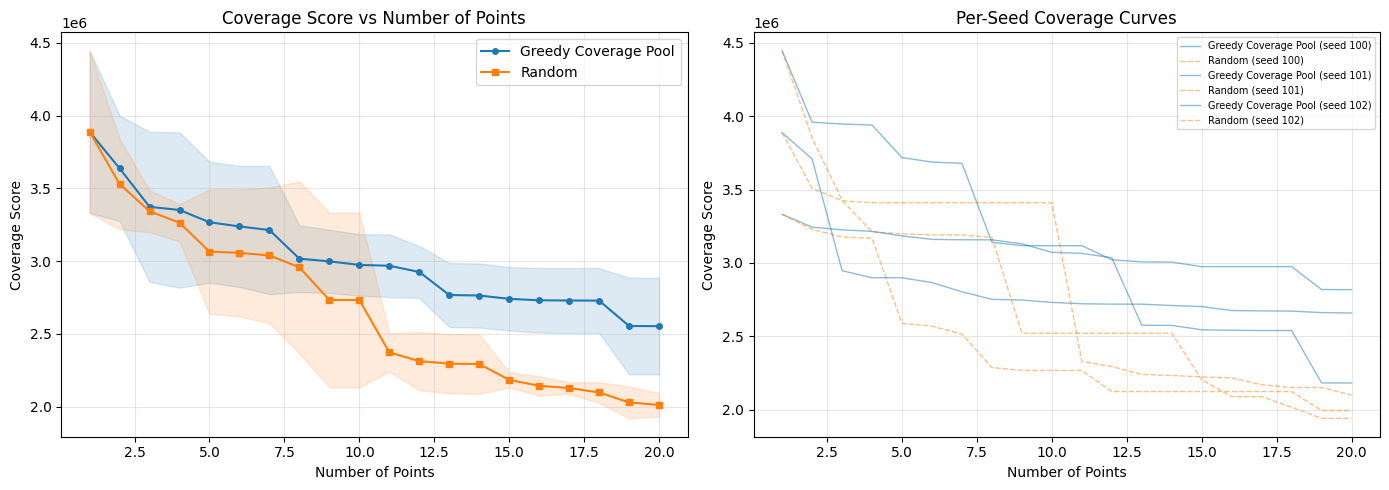


Final Coverage Scores (at n_points=20)
--------------------------------------------------
  Greedy Coverage Pool     : mean=2552428.7938 ± 330994.6713
  Random                   : mean=2010953.5617 ± 80563.0544

  Mann-Whitney U (Greedy < Random): p=1.0000 (n.s.)
  Greedy improvement over Random: -26.9%


In [38]:
# ============================================================
# Incremental Comparison Analysis & Visualization
# ============================================================

# --- 1. Coverage curves: averaged over seeds ---
summary_by_np = (
    df_results.groupby(["Method", "n_points"])["Coverage Score"]
    .agg(["mean", "std"])
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for method, color, marker in [
    ("Greedy Coverage Pool", "tab:blue", "o"),
    ("Random", "tab:orange", "s"),
]:
    method_data = summary_by_np[summary_by_np["Method"] == method]
    n_pts = method_data["n_points"].values
    mean_vals = method_data["mean"].values
    std_vals = method_data["std"].values

    axes[0].plot(
        n_pts,
        mean_vals,
        marker=marker,
        label=method,
        color=color,
        linewidth=1.5,
        markersize=4,
    )
    axes[0].fill_between(
        n_pts, mean_vals - std_vals, mean_vals + std_vals, alpha=0.15, color=color
    )

axes[0].set_xlabel("Number of Points")
axes[0].set_ylabel("Coverage Score")
axes[0].set_title("Coverage Score vs Number of Points")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Per-seed coverage curves
for seed in SEEDS:
    df_seed = df_results[df_results["Seed"] == seed]
    for method, color, ls in [
        ("Greedy Coverage Pool", "tab:blue", "-"),
        ("Random", "tab:orange", "--"),
    ]:
        df_m = df_seed[df_seed["Method"] == method]
        axes[1].plot(
            df_m["n_points"],
            df_m["Coverage Score"],
            linestyle=ls,
            color=color,
            alpha=0.5,
            linewidth=1,
            label=f"{method} (seed {seed})",
        )

axes[1].set_xlabel("Number of Points")
axes[1].set_ylabel("Coverage Score")
axes[1].set_title("Per-Seed Coverage Curves")
handles, labels = axes[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[1].legend(by_label.values(), by_label.keys(), fontsize=7)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 2. Final point statistics ---
df_final = df_results[df_results["n_points"] == TOTAL_POINTS]
print("\nFinal Coverage Scores (at n_points={})".format(TOTAL_POINTS))
print("-" * 50)
for method in ["Greedy Coverage Pool", "Random"]:
    scores = df_final[df_final["Method"] == method]["Coverage Score"]
    print(f"  {method:25s}: mean={scores.mean():.4f} ± {scores.std():.4f}")

# Statistical test
greedy_scores = df_final[df_final["Method"] == "Greedy Coverage Pool"][
    "Coverage Score"
].values
random_scores = df_final[df_final["Method"] == "Random"]["Coverage Score"].values
if len(greedy_scores) >= 2 and len(random_scores) >= 2:
    _, p_val = stats.mannwhitneyu(greedy_scores, random_scores, alternative="less")
    print(
        f"\n  Mann-Whitney U (Greedy < Random): p={p_val:.4f} {'*' if p_val < 0.05 else '(n.s.)'}"
    )

improvement = (random_scores.mean() - greedy_scores.mean()) / random_scores.mean() * 100
print(f"  Greedy improvement over Random: {improvement:+.1f}%")

## Multi-Range Initial Conditions Comparison

Test different GCAS parameter ranges and compare Greedy Coverage Pool vs Random.
Fixed parameters: `psi=0`, `power=9`. Varying: `vt`, `alpha`, `beta`, `phi`, `theta`, `alt`.


In [34]:
# ============================================================
# Multi-Range Initial Conditions Comparison
# ============================================================
# Test different GCAS parameter ranges and compare Greedy Coverage Pool vs Random.
# Fixed: psi=0, power=9. Varying: vt, alpha, beta, phi, theta, alt.

# Define range configurations to test
RANGE_CONFIGS = [
    {
        "name": "Default",
        "vt": (400.0, 800.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-90.0), np.deg2rad(0.0)),
        "alt": (500.0, 6000.0),
    },
    {
        "name": "Low altitude",
        "vt": (400.0, 800.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-90.0), np.deg2rad(0.0)),
        "alt": (500.0, 2000.0),
    },
    {
        "name": "High altitude",
        "vt": (400.0, 800.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-90.0), np.deg2rad(0.0)),
        "alt": (3000.0, 6000.0),
    },
    {
        "name": "Slow velocity",
        "vt": (400.0, 600.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-90.0), np.deg2rad(0.0)),
        "alt": (500.0, 6000.0),
    },
    {
        "name": "Fast velocity",
        "vt": (600.0, 800.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-90.0), np.deg2rad(0.0)),
        "alt": (500.0, 6000.0),
    },
    {
        "name": "Steep dive (theta -90 to -45 deg)",
        "vt": (400.0, 800.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-90.0), np.deg2rad(-45.0)),
        "alt": (500.0, 6000.0),
    },
    {
        "name": "Shallow dive (theta -45 to 0 deg)",
        "vt": (400.0, 800.0),
        "alpha": (np.deg2rad(0.0), np.deg2rad(10.0)),
        "beta": (np.deg2rad(-20.0), np.deg2rad(20.0)),
        "phi": (np.deg2rad(-180.0), np.deg2rad(180.0)),
        "theta": (np.deg2rad(-45.0), np.deg2rad(0.0)),
        "alt": (500.0, 6000.0),
    },
]


def sample_custom_initial_conditions(n_samples, config, seed=None):
    """Sample initial conditions with custom GCAS parameter bounds.
    Returns array of shape (n_samples, 6) with [vt, alpha, beta, phi, theta, alt].
    """
    if seed is not None:
        np.random.seed(seed)

    bounds_lower = np.array(
        [
            config["vt"][0],
            config["alpha"][0],
            config["beta"][0],
            config["phi"][0],
            config["theta"][0],
            config["alt"][0],
        ]
    )
    bounds_upper = np.array(
        [
            config["vt"][1],
            config["alpha"][1],
            config["beta"][1],
            config["phi"][1],
            config["theta"][1],
            config["alt"][1],
        ]
    )

    samples = np.random.uniform(bounds_lower, bounds_upper, (n_samples, 6))
    return samples


# Experiment parameters
RANGE_SEEDS = [100, 101, 102]
RANGE_TOTAL_POINTS = 15
RANGE_N_VAL = 150
RANGE_N_POOL = 300

range_all_results = []

print(
    f"Multi-Range Comparison: {len(RANGE_CONFIGS)} configs × {len(RANGE_SEEDS)} seeds"
)
print(f"Points={RANGE_TOTAL_POINTS}, Val={RANGE_N_VAL}, Pool={RANGE_N_POOL}")
print()

for cfg_idx, config in enumerate(RANGE_CONFIGS):
    config_name = config["name"]
    print(f"\n{'='*70}")
    print(f"CONFIG {cfg_idx+1}/{len(RANGE_CONFIGS)}: {config_name}")
    print(f"  Velocity:  {config['vt']}")
    print(f"  Altitude:  {config['alt']}")
    print(
        f"  Theta:     ({np.rad2deg(config['theta'][0]):.0f}, {np.rad2deg(config['theta'][1]):.0f}) deg"
    )
    print(f"{'='*70}")

    for seed in RANGE_SEEDS:
        np.random.seed(seed)
        print(f"\n  Seed {seed}:")

        # Generate initial point, validation set, pool
        init_point = sample_custom_initial_conditions(1, config, seed=seed * 7)
        val_initial_conds = sample_custom_initial_conditions(
            RANGE_N_VAL, config, seed=seed * 13
        )
        pool_initial_conds = sample_custom_initial_conditions(
            RANGE_N_POOL, config, seed=seed * 17
        )

        # ---- Pre-compute trajectories ----
        print(f"    Pre-computing trajectories...", end=" ")
        start_time = time.time()

        combined_conds = np.vstack([init_point, pool_initial_conds])
        n_combined = len(combined_conds)

        pool_cases = initial_conditions_to_testcases(combined_conds)
        pool_results_list = evaluate_cases(pool_cases)

        # Track which combined_conds indices produced valid simulations
        valid_pool_indices = [
            i for i, r in enumerate(pool_results_list) if not r.simulation_failed
        ]
        pool_trajectories = [
            pool_results_list[i].trajectory for i in valid_pool_indices
        ]
        # Mapping: valid_pool_idx (0..n_pool-1) <-> combined_conds idx
        cond_to_pool = {
            cond_idx: pool_idx for pool_idx, cond_idx in enumerate(valid_pool_indices)
        }

        val_cases = initial_conditions_to_testcases(val_initial_conds)
        val_results_list = evaluate_cases(val_cases)
        val_trajectories = [
            r.trajectory for r in val_results_list if not r.simulation_failed
        ]

        all_trajectories_combined = pool_trajectories + val_trajectories
        n_pool = len(pool_trajectories)
        n_val = len(val_trajectories)

        if n_pool < 2 or n_val < 2:
            print(f"SKIP (pool={n_pool}, val={n_val})")
            continue

        full_dist_matrix = pairwise_distances(
            all_trajectories_combined, distance_type="dtw"
        )
        pool_to_val_dist = full_dist_matrix[:n_pool, n_pool:]

        pool_time = time.time() - start_time
        n_failed = n_combined - n_pool
        print(f"done ({pool_time:.1f}s, pool={n_pool}/{n_combined} valid, val={n_val})")

        # ---- Greedy Coverage Pool: incremental selection ----
        # Use pool-space indices (into pool_to_val_dist) for selection
        # Index 0 in valid_pool_indices corresponds to the first valid simulation
        # We need to check if init_point (combined_conds[0]) is valid
        if 0 not in cond_to_pool:
            print(f"    SKIP: initial point simulation failed")
            continue

        greedy_selected_pool_indices = [
            cond_to_pool[0]
        ]  # pool-space index of init point
        greedy_history = []

        # Initial coverage
        init_val_min_dists = pool_to_val_dist[greedy_selected_pool_indices[0], :]
        init_score = np.mean(init_val_min_dists) + 0.5 * np.max(init_val_min_dists)
        greedy_history.append({"n_points": 1, "coverage_score": init_score})

        # Valid pool indices available for selection (exclude init point's pool index)
        available_pool_indices = [
            pool_idx
            for pool_idx in range(n_pool)
            if pool_idx != greedy_selected_pool_indices[0]
        ]

        n_cycles = RANGE_TOTAL_POINTS - 1
        for cycle in range(n_cycles):
            if not available_pool_indices:
                break

            selected_list = list(greedy_selected_pool_indices)
            current_val_min_dists = np.min(pool_to_val_dist[selected_list, :], axis=0)

            best_pool_idx = None
            best_score = np.inf
            for pool_idx in available_pool_indices:
                candidate_dists = pool_to_val_dist[pool_idx, :]
                new_val_min_dists = np.minimum(current_val_min_dists, candidate_dists)
                score = np.mean(new_val_min_dists) + 0.5 * np.max(new_val_min_dists)
                if score < best_score:
                    best_score = score
                    best_pool_idx = pool_idx

            greedy_selected_pool_indices.append(best_pool_idx)
            available_pool_indices.remove(best_pool_idx)
            greedy_history.append(
                {
                    "n_points": cycle + 2,
                    "coverage_score": best_score,
                }
            )

        # ---- Random: incremental selection ----
        random_history = []
        random_selected_conds = init_point.copy()
        random_history.append({"n_points": 1, "coverage_score": init_score})

        for cycle in range(n_cycles):
            random_new = sample_custom_initial_conditions(
                1, config, seed=seed * 10000 + cycle
            )
            random_selected_conds = np.vstack([random_selected_conds, random_new])

            random_cov = evaluate_coverage_actual(
                random_selected_conds, val_initial_conds, verbose=False
            )
            random_history.append(
                {
                    "n_points": cycle + 2,
                    "coverage_score": random_cov["coverage_score"],
                }
            )

        # ---- Store results ----
        for entry in greedy_history:
            range_all_results.append(
                {
                    "Config": config_name,
                    "Seed": seed,
                    "n_points": entry["n_points"],
                    "Method": "Greedy Coverage Pool",
                    "Coverage Score": entry["coverage_score"],
                }
            )
        for entry in random_history:
            range_all_results.append(
                {
                    "Config": config_name,
                    "Seed": seed,
                    "n_points": entry["n_points"],
                    "Method": "Random",
                    "Coverage Score": entry["coverage_score"],
                }
            )

        # Print final scores
        greedy_final = greedy_history[-1]["coverage_score"]
        random_final = random_history[-1]["coverage_score"]
        improvement = (random_final - greedy_final) / random_final * 100
        print(
            f"    Final scores: Greedy={greedy_final:.2f}, Random={random_final:.2f} ({improvement:+.1f}% improvement)"
        )

Multi-Range Comparison: 7 configs × 3 seeds
Points=15, Val=150, Pool=300


CONFIG 1/7: Default
  Velocity:  (400.0, 800.0)
  Altitude:  (500.0, 6000.0)
  Theta:     (-90, 0) deg

  Seed 100:
    Pre-computing trajectories... 

KeyboardInterrupt: 

In [ ]:
# ============================================================
# Multi-Range Results Analysis & Visualization
# ============================================================

df_range = pd.DataFrame(range_all_results)

# --- 1. Summary table ---
df_final_range = df_range[df_range["n_points"] == RANGE_TOTAL_POINTS]
print("=" * 70)
print("Final Coverage Scores by Range Config (mean ± std over seeds)")
print("=" * 70)
for config_name in [c["name"] for c in RANGE_CONFIGS]:
    df_cfg = df_final_range[df_final_range["Config"] == config_name]
    greedy_scores = df_cfg[df_cfg["Method"] == "Greedy Coverage Pool"]["Coverage Score"]
    random_scores = df_cfg[df_cfg["Method"] == "Random"]["Coverage Score"]
    g_mean, g_std = greedy_scores.mean(), greedy_scores.std()
    r_mean, r_std = random_scores.mean(), random_scores.std()
    improvement = (r_mean - g_mean) / r_mean * 100 if r_mean > 0 else 0
    print(
        f"  {config_name:<35s} | Greedy: {g_mean:>10.2f} ± {g_std:>7.2f} | Random: {r_mean:>10.2f} ± {r_std:>7.2f} | Δ: {improvement:+.1f}%"
    )

# --- 2. Coverage curves: one subplot per config ---
configs_list = [c["name"] for c in RANGE_CONFIGS]
n_configs = len(configs_list)
ncols = min(4, n_configs)
nrows = (n_configs + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)

for idx, config_name in enumerate(configs_list):
    row, col = divmod(idx, ncols)
    ax = axes[row][col]
    df_cfg = df_range[df_range["Config"] == config_name]

    summary_by_np = (
        df_cfg.groupby(["Method", "n_points"])["Coverage Score"]
        .agg(["mean", "std"])
        .reset_index()
    )

    for method, color, marker in [
        ("Greedy Coverage Pool", "tab:blue", "o"),
        ("Random", "tab:orange", "s"),
    ]:
        method_data = summary_by_np[summary_by_np["Method"] == method]
        n_pts = method_data["n_points"].values
        mean_vals = method_data["mean"].values
        std_vals = method_data["std"].values

        ax.plot(
            n_pts,
            mean_vals,
            marker=marker,
            label=method,
            color=color,
            linewidth=1.5,
            markersize=3,
        )
        ax.fill_between(
            n_pts, mean_vals - std_vals, mean_vals + std_vals, alpha=0.15, color=color
        )

    ax.set_xlabel("Number of Points")
    ax.set_ylabel("Coverage Score")
    ax.set_title(config_name, fontsize=10)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=7)

# Hide unused subplots
for idx in range(n_configs, nrows * ncols):
    row, col = divmod(idx, ncols)
    axes[row][col].set_visible(False)

plt.suptitle("Coverage Score vs Points by IC Range (GCAS)", fontsize=13)
plt.tight_layout()
plt.show()

# --- 3. Bar chart: final scores per config ---
fig, ax = plt.subplots(figsize=(10, 5))

config_names = []
greedy_means = []
random_means = []
improvements = []

for config_name in configs_list:
    df_cfg_final = df_final_range[df_final_range["Config"] == config_name]
    g_mean = df_cfg_final[df_cfg_final["Method"] == "Greedy Coverage Pool"][
        "Coverage Score"
    ].mean()
    r_mean = df_cfg_final[df_cfg_final["Method"] == "Random"]["Coverage Score"].mean()
    config_names.append(config_name)
    greedy_means.append(g_mean)
    random_means.append(r_mean)
    improvements.append((r_mean - g_mean) / r_mean * 100 if r_mean > 0 else 0)

x = np.arange(len(config_names))
width = 0.35

ax.bar(
    x - width / 2,
    greedy_means,
    width,
    label="Greedy Coverage Pool",
    color="tab:blue",
    alpha=0.8,
)
ax.bar(
    x + width / 2, random_means, width, label="Random", color="tab:orange", alpha=0.8
)

ax.set_ylabel("Final Coverage Score (lower = better)")
ax.set_title("Final Coverage Score by IC Range (GCAS)")
ax.set_xticks(x)
ax.set_xticklabels(config_names, rotation=30, ha="right", fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# --- 4. Improvement bar chart ---
fig, ax = plt.subplots(figsize=(10, 4))
colors = ["tab:green" if imp > 0 else "tab:red" for imp in improvements]
ax.bar(config_names, improvements, color=colors, alpha=0.8)
ax.set_ylabel("Greedy Improvement over Random (%)")
ax.set_title("Greedy Coverage Pool Improvement by IC Range (GCAS)")
ax.set_xticklabels(config_names, rotation=30, ha="right", fontsize=9)
ax.axhline(y=0, color="black", linewidth=0.5)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# --- 5. Statistical tests per config ---
print("\nStatistical Tests (Mann-Whitney U) per Config at final point count:")
print("-" * 70)
for config_name in configs_list:
    df_cfg_final = df_final_range[df_final_range["Config"] == config_name]
    greedy_scores = df_cfg_final[df_cfg_final["Method"] == "Greedy Coverage Pool"][
        "Coverage Score"
    ].values
    random_scores = df_cfg_final[df_cfg_final["Method"] == "Random"][
        "Coverage Score"
    ].values
    if len(greedy_scores) >= 2 and len(random_scores) >= 2:
        _, p_val = stats.mannwhitneyu(greedy_scores, random_scores, alternative="less")
        print(
            f"  {config_name:<35s}: p={p_val:.4f} {'*' if p_val < 0.05 else '(n.s.)'}"
        )
    else:
        print(f"  {config_name:<35s}: insufficient samples")